In [1]:
from pyspark.sql import SparkSession, Row
import os
import base64
from io import BytesIO
from scipy.io import wavfile
import pandas as pd
from IPython.display import display, Audio
import matplotlib.pyplot as plt
import numpy as np
from pyspark.sql.functions import explode, col
import pyspark.sql.functions as F

In [9]:
import findspark
findspark.init('/usr/lib/spark2')

os.environ["PYSPARK_PYTHON"] = os.path.join("/usr/lib/anaconda-wmf", "bin", "python3")
builder = SparkSession.builder.master("yarn").appName("akhatun-dse-hack")
ENV_VARS_TO_PROPAGATE = [
    'http_proxy',
    'https_proxy',
    'no_proxy',
]
spark_config = {
            "spark.driver.memory": "16g",
            "spark.dynamicAllocation.maxExecutors": 128,
            "spark.executor.memory": "16g",
            "spark.executor.cores": 8,
            "spark.sql.shuffle.partitions": 512,
            'spark.jars.packages': 'org.apache.spark:spark-avro_2.11:2.4.4'
        }
for var in ENV_VARS_TO_PROPAGATE:
    if var in os.environ:
        builder.config(f"spark.executorEnv.{var}", os.environ[var])
        builder.config(f"spark.yarn.appMasterEnv.{var}", os.environ[var])
    for k, v in spark_config.items():
        builder.config(k, v)

spark = builder.getOrCreate()

## Load data

In [10]:
wav_file_df = spark.read.format("avro").load("hdfs://analytics-hadoop/user/fab/commons_sounds/wav_file")

In [6]:
wav_file_df.select("page_id").distinct().count()

594523

In [6]:
wav_file_df.count()

594523

In [5]:
wav_file_df.printSchema()

root
 |-- page_id: long (nullable = true)
 |-- page_namespace: integer (nullable = true)
 |-- page_title: string (nullable = true)
 |-- page_redirect_title: string (nullable = true)
 |-- page_restrictions: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- user_id: long (nullable = true)
 |-- user_text: string (nullable = true)
 |-- revision_id: long (nullable = true)
 |-- revision_parent_id: long (nullable = true)
 |-- revision_timestamp: string (nullable = true)
 |-- revision_minor_edit: boolean (nullable = true)
 |-- revision_comment: string (nullable = true)
 |-- revision_text_bytes: long (nullable = true)
 |-- revision_text_sha1: string (nullable = true)
 |-- revision_text: string (nullable = true)
 |-- revision_content_model: string (nullable = true)
 |-- revision_content_format: string (nullable = true)
 |-- snapshot: string (nullable = true)
 |-- wiki_db: string (nullable = true)
 |-- file_name: string (nullable = true)
 |-- project: string (nullable =

In [64]:
wav_file_df.select("page_namespace", "page_title", "snapshot", "wiki_db", "file_name", "project").show(5, truncate=False)

+--------------+------------------------------------------------+--------+-----------+-------------------------------------------+-------+
|page_namespace|page_title                                      |snapshot|wiki_db    |file_name                                  |project|
+--------------+------------------------------------------------+--------+-----------+-------------------------------------------+-------+
|6             |File:LL-Q150 (fra)-WikiLucas00-brichebrocher.wav|2021-08 |commonswiki|LL-Q150_(fra)-WikiLucas00-brichebrocher.wav|commons|
|6             |File:LL-Q7913 (ron)-KlaudiuMihaila-Potecu.wav   |2021-08 |commonswiki|LL-Q7913_(ron)-KlaudiuMihaila-Potecu.wav   |commons|
|6             |File:Kotadro.wav                                |2021-08 |commonswiki|Kotadro.wav                                |commons|
|6             |File:LL-Q9610 (ben)-Titodutta-ঔর্ব.wav          |2021-08 |commonswiki|LL-Q9610_(ben)-Titodutta-ঔর্ব.wav          |commons|
|6             |File:LL-Q87

In [10]:
wav_file_df.show(5, truncate=False)

+---------+--------------+------------------------------------------------+-------------------+-----------------+-------+--------------+-----------+------------------+--------------------+-------------------+-----------------------------------------------------------------------------------------+-------------------+-------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+----------------------+-----------------------+--------+-----------+-------------------------------------------+-------+-----------------------------------------------------------------------------------------------------------------------------------

## Check few files

https://www.kdnuggets.com/2020/02/audio-data-analysis-deep-learning-python-part-1.html

#### Audio file overview
 
The sound excerpts are digital audio files in .wav format. Sound waves are digitized by sampling them at discrete intervals known as the sampling rate (typically 44.1kHz for CD-quality audio meaning samples are taken 44,100 times per second).

Each sample is the amplitude of the wave at a particular time interval, where the bit depth determines how detailed the sample will be also known as the dynamic range of the signal (typically 16bit which means a sample can range from 65,536 amplitude values).

#### What is Sampling and Sampling frequency?

In signal processing, sampling is the reduction of a continuous signal into a series of discrete values. The sampling frequency or rate is the number of samples taken over some fixed amount of time. A high sampling frequency results in less information loss but higher computational expense, and low sampling frequencies have higher information loss but are fast and cheap to compute.

In [5]:
wav_codes = [wav['file_bytes_b64'] for wav in wav_file_df.select('file_bytes_b64').limit(5).collect()]

In [6]:
wav_data = [wavfile.read(BytesIO(base64.b64decode(code))) for code in wav_codes]

In [7]:
wav_data

[(44100, array([-1,  0,  2, ...,  7,  6,  5], dtype=int16)),
 (44100, array([5, 6, 5, ..., 4, 5, 6], dtype=int16)),
 (16000, array([  2,   6,   3, ...,  -2,  33, -36], dtype=int16)),
 (48000, array([-3, -2, -1, ..., -6, -4, -5], dtype=int16)),
 (48000, array([ 0,  0,  0, ...,  0,  0, -1], dtype=int16))]

In [8]:
## seconds
len(wav_data[0][1])/44100

1.3145578231292516

In [9]:
def show_audio(index):
    data = wav_data[index][1]
    sr = wav_data[index][0]

    display(Audio(data=data, rate=sr))

    print("Smapling rate:", sr, "; Seconds:", round(data.shape[0]/sr, 2))

    plt.figure(figsize=(10,6))
    time = np.linspace(0,len(data)/sr, num=len(data))
    plt.title("Sound Wave")
    plt.xlabel("Time")
    plt.ylabel("Aplitute")
    plt.plot(time, data);

Smapling rate: 44100 ; Seconds: 1.06


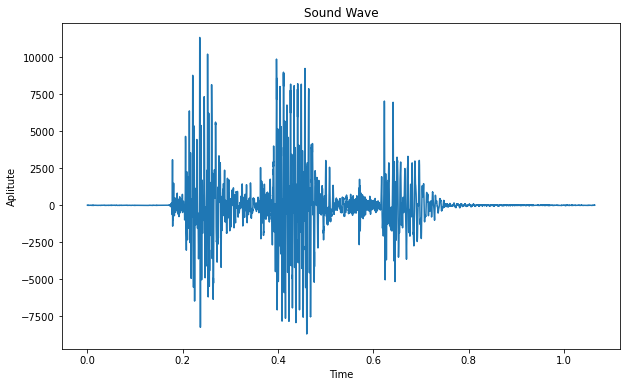

In [10]:
show_audio(1)

Smapling rate: 16000 ; Seconds: 1.3


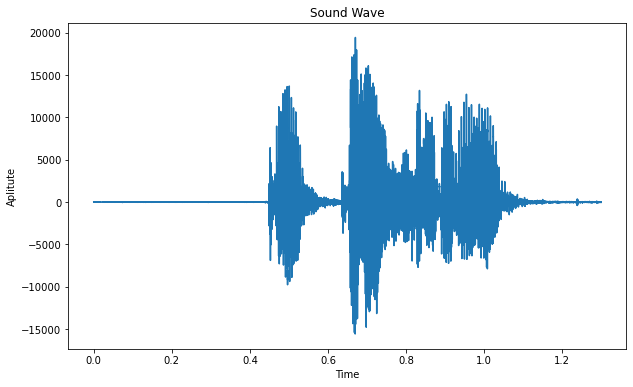

In [11]:
show_audio(2)

Smapling rate: 48000 ; Seconds: 1.05


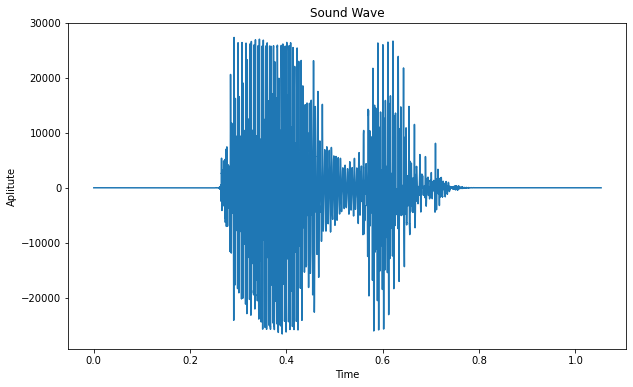

In [12]:
show_audio(3)

## Try Audio mashup with Nsynth

In [2]:
from magenta.models.nsynth import utils
from magenta.models.nsynth.wavenet import fastgen

ModuleNotFoundError: No module named 'magenta'

## Save data in df

In [16]:
## Edited Fabian's code to add data as well

@F.udf(returnType="struct<sample_rate:int,seconds:float,data:array<int>>")
def read_wav(file_bytes_b64):
    file = BytesIO(base64.b64decode(file_bytes_b64))
    try:
        sample_rate, data =  wavfile.read(file)
        # data=data.ravel()
        return Row(sample_rate=sample_rate, seconds=(data.shape[0]/sample_rate), data=data.tolist())
    except Exception as e:
        # TODO
        # haven't investigated, but this does happen
        print("error loading wav")
        
wav_file_data_df = wav_file_df.limit(10000).select("page_id", "file_bytes_b64")\
                              .withColumn('wav', read_wav("file_bytes_b64"))
wav_file_data_df.cache()

display(wav_file_data_df.select("wav.sample_rate").summary().toPandas())
display(wav_file_data_df.select("wav.seconds").summary().toPandas())

,summary,sample_rate
0,count,9970
1,mean,45522.86860581745
2,stddev,8145.850337239782
3,min,8000
4,25%,44100
5,50%,48000
6,75%,192000
7,max,192000


,summary,seconds
0,count,9970
1,mean,1.4876312946753134
2,stddev,2.317381806076337
3,min,0.35174602
4,25%,1.1287981
5,50%,1.3093333
6,75%,83.37329
7,max,83.37329


In [ ]:
# wav_file_data_df.count() ## 594523 original